In [26]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/retinal-image-dataset-of-infants-and-rop/infant_retinal_database_info.csv
/kaggle/input/retinal-image-dataset-of-infants-and-rop/infant_retinal_database_info.xlsx
/kaggle/input/retinal-image-dataset-of-infants-and-rop/images_stack_without_captions/images_stack_without_captions/019_M_GA35_BW3050_PA46_DG11_PF0_D1_S03_3.jpg
/kaggle/input/retinal-image-dataset-of-infants-and-rop/images_stack_without_captions/images_stack_without_captions/164_F_GA30_BW1490_PA32_DG0_PF0_D3_S01_2.jpg
/kaggle/input/retinal-image-dataset-of-infants-and-rop/images_stack_without_captions/images_stack_without_captions/120_M_GA31_BW1670_PA39_DG0_PF0_D2_S03_15.jpg
/kaggle/input/retinal-image-dataset-of-infants-and-rop/images_stack_without_captions/images_stack_without_captions/138_F_GA26_BW680_PA35_DG3_PF2_D2_S03_5.jpg
/kaggle/input/retinal-image-dataset-of-infants-and-rop/images_stack_without_captions/images_stack_without_captions/093_M_GA31_BW1590_PA34_DG0_PF0_D2_S01_1.jpg
/kaggle/input/retinal-image

In [27]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import shutil
import random
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [28]:
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_CHANNELS = 3
BATCH_SIZE = 16
EPOCHS = 70
SPLIT_RATIO = 0.8 

In [29]:
ALL_GOOD_IMAGES_DIR = r'/kaggle/input/retinal-image-dataset-of-infants-and-rop/images_stack_without_captions/images_stack_without_captions'
#ALL_GOOD_IMAGES_DIR = os.path.join(data_path, 'images_stack_without_captions') # Directory where all good images are initially stored
 # Directory with ONLY good images for validation
#TEST_DIR = os.path.join(data_path, 'test')            # Optional: a mixed set of good/poor images for evaluation
MODEL_SAVE_PATH = '/kaggle/working/fundus_autoencoder.keras'

In [30]:
def process_path(file_path):
    """Loads, decodes, resizes, and normalizes an image file."""
    img = tf.io.read_file(file_path)
    # Use expand_animations=False to handle GIFs correctly by only taking the first frame.
    img = tf.io.decode_image(img, channels=IMAGE_CHANNELS, expand_animations=False)
    img = tf.image.resize(img, [IMAGE_HEIGHT, IMAGE_WIDTH])
    img = tf.cast(img, tf.float32) / 255.0
    return img, img # For an autoencoder, the input and target are the same

In [31]:
def create_datasets_from_dir(source_dir, split_ratio, batch_size):
    """
    Creates training and validation tf.data.Dataset objects from a directory of images
    without writing any new files to disk.
    """
    print("--- Creating datasets from source directory ---")
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']
    all_filepaths = [os.path.join(source_dir, f) for f in os.listdir(source_dir)
                     if os.path.splitext(f)[1].lower() in image_extensions]

    if not all_filepaths:
        print(f"Error: No images found in '{source_dir}'. Please add your 'good' quality images there.")
        exit()

    random.shuffle(all_filepaths)
    split_index = int(len(all_filepaths) * split_ratio)
    train_paths = all_filepaths[:split_index]
    val_paths = all_filepaths[split_index:]

    print(f"Found {len(all_filepaths)} images.")
    print(f"Splitting into {len(train_paths)} training and {len(val_paths)} validation samples.")

    train_ds = tf.data.Dataset.from_tensor_slices(train_paths)
    val_ds = tf.data.Dataset.from_tensor_slices(val_paths)

    # Use AUTOTUNE to dynamically optimize performance
    AUTOTUNE = tf.data.AUTOTUNE

    train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
    train_ds = train_ds.shuffle(buffer_size=len(train_paths)).batch(batch_size).prefetch(buffer_size=AUTOTUNE)

    val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)
    val_ds = val_ds.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

    return train_ds, val_ds

In [32]:
def create_autoencoder():
    """
    Creates the convolutional autoencoder model architecture.
    The model learns to compress (encode) and then reconstruct (decode) input images.
    """
    # --- Encoder ---
    input_img = Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)  # Bottleneck layer

    # --- Decoder ---
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(IMAGE_CHANNELS, (3, 3), activation='sigmoid', padding='same')(x)

    # Compile autoencoder
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    autoencoder.summary()
    return autoencoder

In [33]:
def plot_loss(history):
    """Plots the training and validation reconstruction loss."""
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Reconstruction Loss (MSE)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

In [34]:
def visualize_reconstructions(model, data_generator):
    """Displays original images and their reconstructions from a tf.data.Dataset."""
    # The fix is to wrap the dataset with iter() to create an iterator
    images, _ = next(iter(dataset))
    reconstructed_images = model.predict(images)
    n = min(5, len(images))
    plt.figure(figsize=(10, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(images[i])
        plt.title("Original")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed_images[i])
        plt.title("Reconstructed")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.suptitle("Original vs. Reconstructed Images")
    plt.show()

In [35]:
def plot_confusion_matrix(cm, class_names):
    """Renders a seaborn heatmap for the confusion matrix."""
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()


In [36]:
def main():
    """Main function to run the data loading, model training, and evaluation."""
    # --- Create Datasets ---
    train_ds, val_ds = create_datasets_from_dir(ALL_GOOD_IMAGES_DIR, SPLIT_RATIO, BATCH_SIZE)

    # --- Model Training ---
    autoencoder = create_autoencoder()
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(MODEL_SAVE_PATH, save_best_only=True, monitor='val_loss', mode='min')

    history = autoencoder.fit(
        train_ds,
        epochs=EPOCHS,
        validation_data=val_ds,
        callbacks=[early_stopping, model_checkpoint]
    )

    plot_loss(history)

    # --- Anomaly Detection Threshold Calculation ---
    print("\n--- Calculating Reconstruction Error Threshold ---")
    # Get all validation images from the dataset
    val_images = np.concatenate([x for x, y in val_ds], axis=0)
    reconstructions = autoencoder.predict(val_images)
    mse = np.mean(np.square(val_images - reconstructions), axis=(1, 2, 3))

    # Threshold is typically mean + N * std_dev
    mean_mse = np.mean(mse)
    std_mse = np.std(mse)
    threshold = mean_mse + (3 * std_mse)

    print(f"Reconstruction Error on 'Good' Validation Images (MSE):")
    print(f"  - Mean: {mean_mse:.6f}")
    print(f"  - Std Dev: {std_mse:.6f}")
    print(f"Calculated Anomaly Threshold: {threshold:.6f}")
    print("Any image with reconstruction error > threshold will be classified as 'poor'.")

    visualize_reconstructions(autoencoder, val_ds)

    # --- (Optional) Evaluate on a Test Set ---
    ''' if os.path.exists(TEST_DIR) and any(os.scandir(TEST_DIR)):
        print("\n--- Evaluating threshold on test set ---")
        test_datagen = ImageDataGenerator(rescale=1./255)
        test_generator = test_datagen.flow_from_directory(
            TEST_DIR,
            target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
            batch_size=BATCH_SIZE,
            class_mode='binary',
            shuffle=False
        )

        # Correctly gather all images and labels from the generator
        test_images = []
        test_labels = []
        for i in range(len(test_generator)):
            img_batch, label_batch = test_generator[i]
            test_images.append(img_batch)
            test_labels.append(label_batch)
        test_images = np.concatenate(test_images, axis=0)
        test_labels = np.concatenate(test_labels, axis=0)

        reconstructed_test = autoencoder.predict(test_images)
        test_mse = np.mean(np.square(test_images - reconstructed_test), axis=(1, 2, 3))

        class_names = {v: k for k, v in test_generator.class_indices.items()}
        print(f"Class indices from test folder: {test_generator.class_indices}")

        poor_class_index = test_generator.class_indices.get('poor', -1)
        if poor_class_index == -1:
             print("Warning: 'poor' class not found in test set. Cannot calculate accuracy.")
             return

        predictions = test_mse > threshold
        correct_predictions = np.sum((test_labels == poor_class_index) == predictions)

        for i, (mse_val, label) in enumerate(zip(test_mse, test_labels)):
            pred_class = 'poor' if mse_val > threshold else 'good'
            print(f"Image {i:02d} (True: {class_names[label]}): MSE={mse_val:.6f} -> Predicted: {pred_class}")

        accuracy = correct_predictions / len(test_labels)
        print(f"\nAccuracy on test set: {accuracy * 100:.2f}%")
    else:
        print("\nSkipping test set evaluation: 'fundus_images/test' directory not found or is empty.")
        print("To evaluate, create it with 'good' and 'poor' subdirectories.")

    print(f"\nModel training complete. Autoencoder saved to '{MODEL_SAVE_PATH}'")
    if os.path.exists(TEST_DIR) and any(os.scandir(TEST_DIR)):
        print("\n--- Evaluating threshold on test set ---")
        test_datagen = ImageDataGenerator(rescale=1./255)
        test_generator = test_datagen.flow_from_directory(
            TEST_DIR,
            target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
            batch_size=BATCH_SIZE,
            class_mode='binary',
            shuffle=False
        )
        test_images, test_labels = [], []
        for i in range(len(test_generator)):
            img_batch, label_batch = test_generator[i]
            test_images.append(img_batch)
            test_labels.append(label_batch)
        test_images = np.concatenate(test_images, axis=0)
        test_labels = np.concatenate(test_labels, axis=0).astype(int)
        
        reconstructed_test = autoencoder.predict(test_images)
        test_mse = np.mean(np.square(test_images - reconstructed_test), axis=(1, 2, 3))

        class_names_map = {v: k for k, v in test_generator.class_indices.items()}
        print(f"Class indices from test folder: {test_generator.class_indices}")
        
        # Ensure 'poor' class is treated as the "positive" class for anomaly detection
        poor_class_index = test_generator.class_indices.get('poor', -1)
        if poor_class_index == -1:
             print("Warning: 'poor' class not found in test set. Cannot calculate metrics.")
             return

        # Predictions: 1 if anomaly ('poor'), 0 if normal ('good')
        predictions_binary = (test_mse > threshold).astype(int)
        true_labels_binary = (test_labels == poor_class_index).astype(int)
        
        # --- NEW: Detailed Classification Metrics ---
        print("\n--- Classification Metrics on Test Set ---")
        
        # 1. Accuracy
        accuracy = accuracy_score(true_labels_binary, predictions_binary)
        print(f"Accuracy: {accuracy * 100:.2f}%")

        # 2. Classification Report (Precision, Recall, F1-Score)
        # Target names should correspond to the binary labels [0, 1]
        target_names = ['good' if i != poor_class_index else 'poor' for i in range(len(class_names_map))]
        print("\nClassification Report:")
        print(classification_report(true_labels_binary, predictions_binary, target_names=target_names))

        # 3. Confusion Matrix
        print("Confusion Matrix:")
        cm = confusion_matrix(true_labels_binary, predictions_binary)
        print(cm)
        plot_confusion_matrix(cm, class_names=target_names)

    else:
        print("\nSkipping test set evaluation: 'fundus_images/test' directory not found or is empty.")
        print("To evaluate metrics, create it with 'good' and 'poor' subdirectories.")
    print(f"\nModel training complete. Autoencoder saved to '{MODEL_SAVE_PATH}'")
'''  


--- Creating datasets from source directory ---
Found 6004 images.
Splitting into 4803 training and 1201 validation samples.


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_6 (UpSampling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 32, 32, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_7 (UpSampling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 64, 64, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_8 (UpSampling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 128, 128, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 333,955 (1.27 MB)

 Trainable params: 333,955 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/70
301/301 ━━━━━━━━━━━━━━━━━━━━ 38s 42ms/step - loss: 0.0221 - val_loss: 0.0016
Epoch 2/70
301/301 ━━━━━━━━━━━━━━━━━━━━ 30s 33ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 3/70
301/301 ━━━━━━━━━━━━━━━━━━━━ 30s 37ms/step - loss: 0.0011 - val_loss: 9.4764e-04
Epoch 4/70
301/301 ━━━━━━━━━━━━━━━━━━━━ 28s 33ms/step - loss: 8.9203e-04 - val_loss: 8.8312e-04
Epoch 5/70
301/301 ━━━━━━━━━━━━━━━━━━━━ 29s 33ms/step - loss: 8.7701e-04 - val_loss: 8.6592e-04
Epoch 6/70
301/301 ━━━━━━━━━━━━━━━━━━━━ 29s 32ms/step - loss: 7.9322e-04 - val_loss: 7.0914e-04
Epoch 7/70
301/301 ━━━━━━━━━━━━━━━━━━━━ 29s 32ms/step - loss: 7.5115e-04 - val_loss: 7.2252e-04
Epoch 8/70
301/301 ━━━━━━━━━━━━━━━━━━━━ 29s 32ms/step - loss: 7.5065e-04 - val_loss: 6.2473e-04
Epoch 9/70
301/301 ━━━━━━━━━━━━━━━━━━━━ 30s 37ms/step - loss: 7.1070e-04 - val_loss: 6.2136e-04
Epoch 10/70
301/301 ━━━━━━━━━━━━━━━━━━━━ 30s 33ms/step - loss: 6.7419e-04 - val_loss: 5.8912e-04
Epoch 11/70
301/301 ━━━━━━━━━━━━━━━━━━━━ 30s 33ms/step - lo

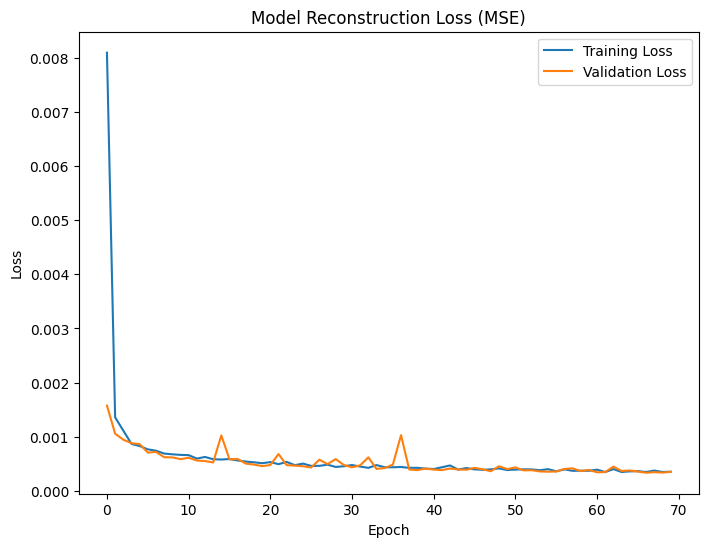


--- Calculating Reconstruction Error Threshold ---
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step
Reconstruction Error on 'Good' Validation Images (MSE):
  - Mean: 0.000338
  - Std Dev: 0.000205
Calculated Anomaly Threshold: 0.000954
Any image with reconstruction error > threshold will be classified as 'poor'.


NameError: name 'dataset' is not defined

In [37]:
if __name__ == '__main__':
    # Ensure the source directory exists before trying to create datasets
    if not os.path.exists(ALL_GOOD_IMAGES_DIR):
        print(f"Error: Source image directory '{ALL_GOOD_IMAGES_DIR}' not found.")
        print("Please create it and place all your 'good' quality images inside.")
    else:
        main()